## Masking in Earth Observation (EO) Analysis with openEO

### Introduction

In Earth Observation (EO) analysis, **masking** is a crucial technique used to focus on specific areas of interest by excluding or "masking out" unwanted data points, such as clouds, water bodies, or urban areas. Masking allows for more accurate analysis by isolating the data that truly matters for your study.

### What is a Mask?

A mask in EO analysis is essentially a filter applied to a data cube or image, where specific pixels are either included or excluded based on certain criteria. These criteria can be simple thresholds (e.g., excluding all pixels with a value below a certain number) or more complex conditions involving specific data bands or bitwise operations.

### Masking Out vs. Masking for Keeps

One common point of confusion is the difference between "masking out" and "masking for keeps":

- **Masking Out**: This refers to the process of excluding or "hiding" certain pixels in the data that do not meet specific criteria. For example, if you're analyzing vegetation, you might mask out all non-vegetated areas.
- **Masking for Keeps**: Conversely, this involves creating a mask to retain only the pixels that meet your criteria, effectively excluding everything else.

In openEO, the `mask` process is used to apply these masks. It removes or excludes the data points where the mask condition is **true**. This means that if your mask identifies non-vegetated areas as `true`, those areas will be excluded (masked out).

### Types of Masks

In this exercise, we will explore two fundamental types of masks commonly used in EO analysis:

1. **Value-Based Masks**: These masks are created by categorizing pixels based on specific values. An example is the **Sentinel-2 Scene Classification Layer (SCL)**, which classifies each pixel into categories such as vegetation, clouds, or water. You can use these classifications to mask out unwanted pixels, like clouds or shadows, and focus on the areas that are most relevant to your analysis.

2. **Bitmask-Based Masks**: These masks utilize bitwise operations to interpret quality metrics encoded in specific bits of each pixel's data. An example is the **Sentinel-3 Quality Flags (WQSF)**, which provide granular information about each pixel, such as the presence of clouds or other conditions. By setting or checking specific bits, you can create masks that exclude pixels based on multiple quality criteria.

### Objective

The objective of this tutorial is to demonstrate how to apply masks in openEO for EO analysis. We will show how to mask out unwanted data using both simple and complex masking techniques, and how to ensure you are correctly interpreting the mask results.

### Concepts Explored in This Notebook

A. **Understanding and Creating Masks**: Learn what a mask is and how to create it using openEO.

B. **Applying Value Based Masks**: Apply a value based  mask to a data cube to focus your analysis on specific areas.

C. **Creating and Applying Bitwise Masks**: Use Sentinel-3 Quality Flags to perform bitwise masking and exclude pixels based on specific quality criteria.

### Tools You'll Use

- **openEO**: To interact with satellite data and apply masks.
- **Matplotlib via `demo_helpers.py`**: To visualize the results of your masking operations.

### Learning Outcomes

By the end of this tutorial, you will be able to:

- Understand the concept of masking in EO analysis and differentiate between "masking out" and "masking for keeps."
- Create masks to exclude or retain specific areas in a data cube based on simple thresholds or complex bitwise operations.
- Use the Sentinel-2 Scene Classification Layer (SCL) to create and apply a value-based mask.
- Utilize Sentinel-3 Quality Flags to create and apply a bitwise mask.
- Visualize and verify the results of your masking operations, ensuring accuracy in your EO analysis.

### Let's Begin

First, we'll import the necessary Python libraries and establish a connection to the openEO backend, as usual. Then, we'll dive into the process of creating and applying masks to our data.


In [5]:
import openeo
from config import user, passwd, eo_service_url
from demo_regions import s2
from demo_helpers import show_result,show_binary_image_thumbnail
import io
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import numpy as np

In [6]:
conn = openeo.connect('http://host.docker.internal:8000')
conn.authenticate_basic(username=user, password=passwd)

<Connection to 'http://host.docker.internal:8000/' with BasicBearerAuth>

### A. Understanding and Creating Masks

#### What is a Mask?

In Earth Observation (EO) analysis, a mask is a filter applied to selectively include or exclude specific pixels in a data cube based on criteria such as value thresholds or bitwise conditions. This process helps focus your analysis on relevant data by removing noise, such as clouds or non-vegetation areas.

#### Types of Masks

Before we create and apply masks, it’s important to understand the two common types of masks used in EO analysis:

1. **Value-Based Masks**: These masks use discrete values to categorize each pixel in the data layer. The Sentinel-2 Scene Classification Layer (SCL) is an example of such a value-based mask. It categorizes pixels into classes like vegetation, clouds, or water, allowing us to mask out unwanted pixels based on their classification. This approach is useful for filtering out entire classes of data, such as clouds or water bodies.


    Below is a simplified table showing SCL values for an imaginary 5x5 pixel image:

    | 4  | 5  | 7  | 4  | 6  |
    |----|----|----|----|----|
    | 3  | 4  | 4  | 5  | 7  |
    | 7  | 6  | 4  | 4  | 4  |
    | 6  | 3  | 5  | 7  | 6  |
    | 4  | 5  | 6  | 4  | 7  |
    | 7  | 4  | 3  | 6  | 4  |

    This table represents a simplified 5x5 grid of SCL values, where each number corresponds to a specific class (e.g., 4 = Vegetation, 5 = Bare Soil, 6 = Water, 7 = Clouds). The position of each number corresponds to a pixel in the data cube, across all bands and time steps. By creating a value-based mask, where pixels with SCL value 4 (vegetation) are set to 1 and others to 0, you can effectively exclude all vegetation pixels from your analysis. Applying this mask to other bands of the same product will allow you to focus on non-vegetated land cover types, refining your analysis to the areas of interest.


2. **Bitwise Masks**: These masks use individual bits in the mask value to classify each corresponding pixel in the data layer. The Sentinel-3 Quality Flags (WSQF) use these bits to indicate various quality metrics. In this way, each "pixel" in the mask can carry more information. Unlike value-based masks, which can indicate whether a corresponding pixel represents vegetation OR water, WSQF can describe a pixel as cloudy AND saturated, or other combinations of conditions. We will look more into the details of such masks further down in this notebook.


#### Creating and Visualizing a Value-Based Mask

Let's start by creating a value-based mask using the Scene Classification Layer (SCL) from Sentinel-2 data. We will exclude all pixels where the SCL value equals 4 (vegetation) and visualize the resulting mask to see which areas will be excluded.


--------------------------------Logical Mask made out of the SCL Mask--------------------------------

33222222222211111111110000000000  33222222222211111111110000000000  33222222222211111111110000000000
10987654321098765432109876543210  10987654321098765432109876543210  10987654321098765432109876543210

_______________________________1   _______________________________1   _______________________________1   
_______________________________1   _______________________________1   _______________________________1   
_______________________________1   _______________________________1   _______________________________1   
_______________________________1   _______________________________1   _______________________________1   
_______________________________1   _______________________________1   _______________________________1   
_______________________________1   _______________________________1   _______________________________1   
_______________________________1   _______________________

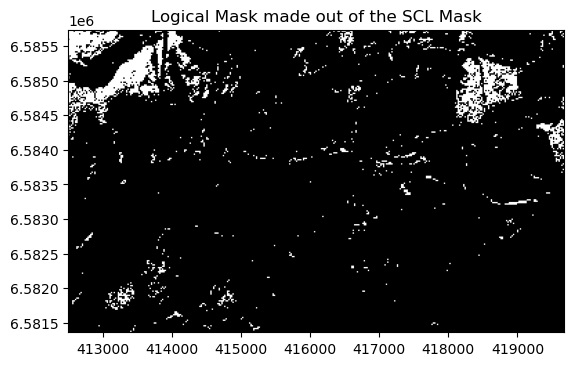

In [11]:
### Example: Creating and Visualizing a Value-Based Mask

from demo_regions import s2

# 1. Load the Sentinel-2 data cube for the Karlstad region, including the SCL band
s2_datacube = conn.load_collection(s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.one_image,
                         bands=["b05", "scl"] 
)

# 2. Create a mask to exclude all pixels where the SCL value equals 4 (vegetation)
vegetation_mask = s2_datacube.band("scl") == 4

# 3. Execute process and Visualize the mask
# Note: This visualization will show the mask itself, highlighting the areas that will be excluded

scl_mask_data = vegetation_mask.download(format="gtiff")
title="Logical Mask made out of the SCL Mask"
scl_mask_image = show_result(scl_mask_data, title=title)
show_binary_image_thumbnail(scl_mask_image, title=title)

Notice the absence of a 1 in the last row of the leftmost column. 
### Explanation of the Code

This code cell walks you through the process of creating and visualizing a value-based mask using Sentinel-2 data in the openEO environment.

1. **Load the Sentinel-2 Data Cube**:
   - In the first step (`# 1`), we load a data cube from the Sentinel-2 dataset that focuses on the Karlstad region. We specifically request the Scene Classification Layer (SCL) band, which classifies each pixel into different categories such as vegetation, water, or clouds. The data is restricted to a specific spatial extent using the `spatial_extent` argument (`s2.bbox.karlstad_mini_land`) and a single time step using the `temporal_extent` argument (`s2.timespans.one_image`).

2. **Create the Mask**:
   - In the second step (`# 2`), we create a mask that identifies all pixels where the SCL value equals 4, representing vegetation. This is done by selecting the "scl" band from the data cube with `s2_datacube.band("scl")` and applying the condition `== 4`. The resulting `vegetation_mask` will be `True` where the condition is met and `False` otherwise. This creats a logical mask that can be applied on your datacube.

3. **Execute the Process and Visualize the Mask**:
   - In the final step (`# 3`), we ask the back-end to execute and download the result as a GeoTIFF using the `download` method. We then visualize the mask using the `show_result` function, which shows the areas that will be excluded where the SCL value equals 4. If you are curious about the `show_result` you may take a look at `demo_helpers.py`, but we will talk about visualization later on in the course.  
 

### B. Applying the Mask

Once we’ve created and visualized the mask, the next step is to apply it to one or more bands in a data cube. This will exclude the masked-out pixels from our analysis, allowing us to focus on the areas of interest.

In this example, we will load the Sentinel-2 band B05, which corresponds to the Red Edge 1 spectral band with a 20-meter resolution. This band is useful for analyzing vegetation and other land cover types. By applying the mask we created earlier, we can exclude areas classified as vegetation (SCL value 4) and focus our analysis on the remaining areas.
Options for Applying the Mask

When applying the mask, you have two main options depending on whether you want to filter out or keep the pixels that match your mask criteria:

- **Filtering Out Pixels:**
This option is used when you want to exclude the pixels that meet the mask condition (e.g., vegetation areas). The masked-out pixels will not be included in your final analysis. <br>
`masked_b05 = b05_datacube.mask(vegetation_mask)`

- **Keeping Pixels**:
This option is used when you want to retain only the pixels that meet the mask condition. Instead of excluding these pixels, you exclude everything else. This is accomplished by inverting the mask: <br>
`masked_b05 = b05_datacube.mask(~vegetation_mask)`
 
Next, we’ll proceed with loading the B05 band and applying the mask we created to see the effect.


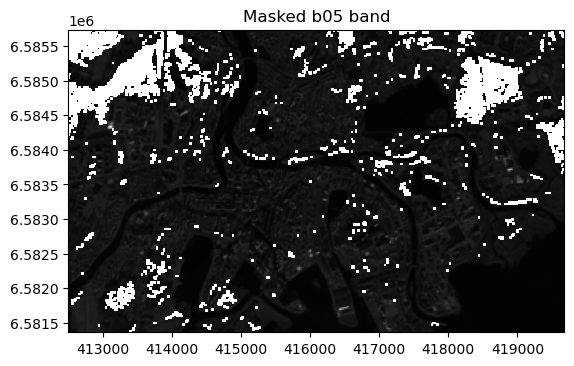

In [14]:
# 1. Load the Sentinel-2 B05 band (Red Edge 1) for the same region and time period
b05_datacube = s2_datacube.band("b05") 

# 2. Apply the vegetation mask to the B05 band
masked_b05 = b05_datacube.mask(vegetation_mask) # Filtering out
#masked_b05 = b05_datacube.mask(~vegetation_mask) # Keeping 

# 3. Execute the process and visualize the masked B05 band
res = masked_b05.download(format="gtiff")
_ = show_result(res, title="Masked b05 band")

### Explaining the Masked Result (Filtering out alternative)

After executing the masking process, the resulting visualization displays the Sentinel-2 **B05 (Red Edge 1)** band with **vegetation areas excluded** based on the mask we applied.

**What You See in the Image:**

- **Visible Pixels**: Represent areas **not classified as vegetation**. These could include urban regions, water bodies, bare soil, or other land cover types. The brightness and tone correspond to the reflectance values captured in the B05 band, which is sensitive to vegetation and soil characteristics.

- **Masked-Out Areas**: Locations where the **SCL value was equal to 4 (vegetation)** appear as **blank or transparent** in the image. These pixels have been excluded from the visualization, effectively allowing you to focus on non-vegetated surfaces.

**Interpretation:**

- The **absence of data** in vegetated regions helps in analyses where vegetation might obscure or interfere with the features of interest, such as studying urban infrastructure, water quality, or soil properties.

- The **contrast between masked and unmasked areas** provides a clear visual distinction, making it easier to identify and analyze specific land cover types without the influence of vegetation.

**Why This Is Useful:**

- **Enhanced Focus**: By removing vegetated areas, analysts can **concentrate on other land features** that are otherwise difficult to observe due to vegetation cover.

- **Data Reduction**: Excluding unnecessary data simplifies processing and can **improve computational efficiency** for subsequent analyses.

- **Improved Accuracy**: Eliminating vegetation can **reduce noise and increase the accuracy** of studies related to urban planning, geology, or hydrology.

**Next Steps:**

- You can go back and try out other values of the SCL band and other bands of the Sentinel2 product. Please remember that you can only work with the 20m bands since the SCL band has that resolution. In upcoming exercises we will learn how to work with bands of different resolutions.  

### C. Creating and Applying a Bitwise Mask

In the previous section, we used a value-based mask to exclude certain areas from our analysis. Now, we'll explore a more advanced technique: bitwise masking, which allows for more granular filtering of pixels based on complex criteria. In this exercise we will use the `wsqf_lsb´mask of our Sentinel3 product. In our product we have split the flag iformation into low bits `lsb` and the high bits `msb`. We will use the low bits in this exercise but the technique applies to the high bits as well. 


Below is a simplified table showing WSQF values for a 5x5 grid with 4-bit values:

| 0101 | 1100 | 0010 | 0111 | 1001 |
|------|------|------|------|------|
| 0001 | 0110 | 1010 | 1000 | 1101 |
| 1110 | 0011 | 0100 | 0110 | 1011 |
| 1000 | 1100 | 0111 | 0001 | 1111 |
| 1010 | 0010 | 1110 | 0111 | 0101 |

Above table represents a simplified 5x5 grid of WSQF values, where each 4-bit value indicates a combination of quality flags (e.g., 0101 might indicate cloud presence and high aerosol content). The WSQF allows for more detailed masking, where multiple conditions can be flagged for each pixel. In this example, a pixel might be excluded if it has both cloud presence and high aerosol content.

#### Sentinel-3 WSQF (Quality Flags)

The Quality Flags band (WSQF), encodes multiple quality indicators for each pixel, such as:

- **Bit 0**: Cloud present
- **Bit 1**: High aerosol content
- **Bit 2**: Saturated pixels
- **Bit 3**: Snow/Ice presence

By targeting specific bits, we can create a mask that excludes pixels flagged with conditions like cloud presence or saturation.

#### Applying a Bitwise Mask

In this exercise, we'll load the WSQF band from Sentinel-3 data and create a bitwise mask to exclude pixels with specific quality issues, such as cloudiness or saturation. Once the mask is created, we'll apply it to another band (e.g., a reflectance band) to refine our analysis by excluding only those pixels that don't meet our quality criteria.

<table>
  <tr>
    <!-- Left Table: Original Values -->
    <td style="padding-right: 20px;">
      <table border="1" cellpadding="10">
        <tr>
          <td>0101</td>
          <td>1100</td>
          <td>0010</td>
          <td>0111</td>
        </tr>
        <tr>
          <td>0001</td>
          <td>0110</td>
          <td>1010</td>
          <td>1000</td>
        </tr>
        <tr>
          <td>1110</td>
          <td>0011</td>
          <td>0100</td>
          <td>0110</td>
        </tr>
        <tr>
          <td>1000</td>
          <td>1100</td>
          <td>0111</td>
          <td>0001</td>
        </tr>
      </table>
    </td>
    <!-- Operator -->
    <td style="padding-left: 20px; padding-right: 20px; vertical-align: middle;">
      &amp; 0b0101
    </td>
    <!-- Middle Table: Result after AND with 0b0101 -->
    <td style="padding-left: 20px;">
      <table border="1" cellpadding="10">
        <tr>
          <td>0101</td>
          <td>0100</td>
          <td>0000</td>
          <td>0101</td>
        </tr>
        <tr>
          <td>0001</td>
          <td>0100</td>
          <td>0000</td>
          <td>0000</td>
        </tr>
        <tr>
          <td>0100</td>
          <td>0001</td>
          <td>0100</td>
          <td>0100</td>
        </tr>
        <tr>
          <td>0000</td>
          <td>0100</td>
          <td>0101</td>
          <td>0001</td>
        </tr>
      </table>
    </td>
    <!-- Operator -->
    <td style="padding-left: 20px; padding-right: 20px; vertical-align: middle;">
      == 0b0101
    </td>
    <!-- Right Table: Resulting Mask for AND Operation -->
    <td style="padding-left: 20px;">
      <table border="1" cellpadding="10">
        <tr>
          <td>1</td>
          <td>0</td>
          <td>0</td>
          <td>1</td>
        </tr>
        <tr>
          <td>0</td>
          <td>0</td>
          <td>0</td>
          <td>0</td>
        </tr>
        <tr>
          <td>0</td>
          <td>0</td>
          <td>0</td>
          <td>0</td>
        </tr>
        <tr>
          <td>0</td>
          <td>0</td>
          <td>1</td>
          <td>0</td>
        </tr>
      </table>
    </td>
  </tr>
  <tr>
    <!-- Empty cell for alignment -->
    <td colspan="3"></td>
    <!-- Operator for OR operation -->
    <td style="padding-left: 20px; padding-right: 20px; vertical-align: middle;">
      > 0
    </td>
    <!-- Resulting Mask for OR Operation -->
    <td>
      <table border="1" cellpadding="10">
        <tr>
          <td>1</td>
          <td>1</td>
          <td>0</td>
          <td>1</td>
        </tr>
        <tr>
          <td>1</td>
          <td>1</td>
          <td>0</td>
          <td>0</td>
        </tr>
        <tr>
          <td>1</td>
          <td>1</td>
          <td>1</td>
          <td>1</td>
        </tr>
        <tr>
          <td>0</td>
          <td>1</td>
          <td>1</td>
          <td>1</td>
        </tr>
      </table>
    </td>
  </tr>
</table>





The leftmost table shows example Water Quality Science Flags (WQSF) for each pixel. Let's say we're interested in analyzing bits 0 and 2. By using a bitwise `&` operation with the mask `0b0101`, we can isolate these specific bits, as shown in the middle table.

From this isolated data, we can create two types of logical masks, which are shown in the tables on the right:

- **Top Right Table**: This mask shows the result of an **AND** operation, where only the pixels that match **all** the selected bits (both bit 0 and bit 2) are kept. This means that only the pixels where both bits are set to `1` will be retained.

- **Bottom Right Table**: This mask shows the result of an **OR** operation, where pixels that match **any** of the selected bits (either bit 0 or bit 2) are kept. This means that if either bit 0 or bit 2 is set to `1`, the pixel will be retained.

When you apply one of these masks to a band, the pixels where the mask has `1s` will be kept in your analysis, while the pixels with `0s` will be excluded and set to NoData.


This approach ensures that the data we analyze is accurate and reliable by filtering out pixels that could distort the results.
In the example below we will do this in a number of steps. First we show the raw WSQF data, then we create the mask  corresponding to the right table above. The last step applies this mask on the `oa08` band. 
 

In [15]:
from demo_regions import s3

# 1. Load the Sentinel-3 data cube for the Karlstad region, including the WSQF and oa08 band
s3_datacube = conn.load_collection(
    s3.s3_olci_l2wfr,
    spatial_extent=s3.bbox.karlstad_mini_sea,
    temporal_extent=s3.timespans.one_image,
    bands=["wqsf_lsb", "oa08"]
)

----------------------------------Original oa08 band before masking----------------------------------

33222222222211111111110000000000  33222222222211111111110000000000  33222222222211111111110000000000
10987654321098765432109876543210  10987654321098765432109876543210  10987654321098765432109876543210

________________________________   ________________________________   ________________________________   
________________________________   ________________________________   ________________________________   
________________________________   ________________________________   ________________________________   
________________________________   ________________________________   ________________________________   
________________________________   -_________________1__111____1111   ________________________________   
________________________________   -_________________1__111____1111   ________________________________   
-_________________1__111____1111   -_________________1__11

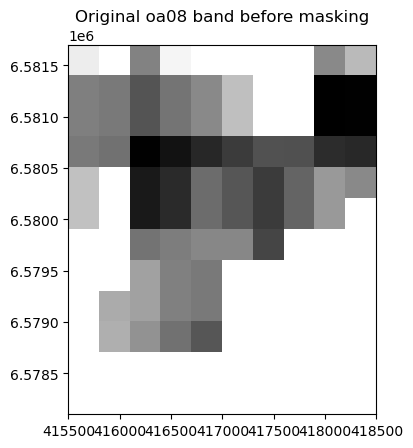

In [18]:
# 2. Extract and view  the oa08 band (red light, 665 nm) for analysis
oa08_band = s3_datacube.band("oa08")
oa08_data = oa08_band.download(format="gtiff")
title="Original oa08 band before masking"
oa08_image = show_result(oa08_data, title=title)
show_binary_image_thumbnail(oa08_image, title=title)

------------------------------------------Original WSQF Band------------------------------------------

33222222222211111111110000000000  33222222222211111111110000000000  33222222222211111111110000000000
10987654321098765432109876543210  10987654321098765432109876543210  10987654321098765432109876543210

___1__1_11_1______________1__1__   ___1__1_11_1______________1__1__   ___1__1_11_1______________1__1__   
___1__11_111______________1__1__   ___1__11_111______________1__1__   ___1__11_1_1______________1__1__   
___1__11_111______________1__1__   ___1__11_111______________1__1__   ___1__11_1_1______________1__1__   
___1__11_1_1____1_________1__1__   ___1__11_1_1____1_________1__1__   ___11_11__1_1_____________1__1__   
___1__11_1_1____1_________1__1__   _______1_____________________1__   ____1_11__111_____________1__1__   
___1__11_1_1____1_________1__1__   _______1_____________________1__   ____1_11__111_____________1__1__   
_____________________________1__   _______1______________

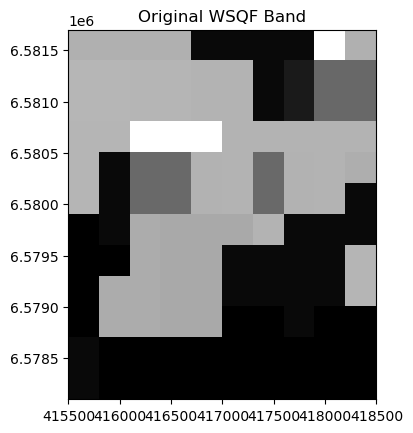

In [20]:
# 3. Extract and view the WSQF band for creating the quality mask
wsqf_band = s3_datacube.band("wqsf_lsb") 

wsqf_data = wsqf_band.download(format="gtiff")
title="Original WSQF Band"
wsqf_image = show_result(wsqf_data, title=title)
show_binary_image_thumbnail(wsqf_image, title=title)

-----------------------WSQF band masked with 00000000000100000000000000000100:-----------------------

33222222222211111111110000000000  33222222222211111111110000000000  33222222222211111111110000000000
10987654321098765432109876543210  10987654321098765432109876543210  10987654321098765432109876543210

___________1_________________1__   ___________1_________________1__   ___________1_________________1__   
___________1_________________1__   ___________1_________________1__   ___________1_________________1__   
___________1_________________1__   ___________1_________________1__   ___________1_________________1__   
___________1_________________1__   ___________1_________________1__   _____________________________1__   
___________1_________________1__   _____________________________1__   ___________1_________________1__   
___________1_________________1__   _____________________________1__   ___________1_________________1__   
_____________________________1__   _______________________

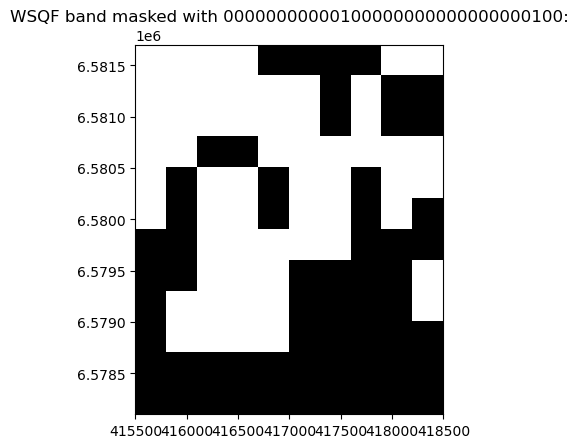

In [21]:
# 4. Select all pixels in the WSWF band where the quality flags indicate coast line (Bit 3) or Sun Glint (Bit 20)
#    Note that we selected those two since they obviously exist in the mask shown above, not because a particular
#    interest or that it would make any sense. Focus here is to show the masking in two steps
selected_bits = 0b00100 | 1<<20 # Bitwise OR operation to combine conditions
masked_wsqf = wsqf_band.process("bitwise_and", x=wsqf_band, y=selected_bits)
  
masked_wsqf_data = masked_wsqf.download(format="gtiff")
title=f"WSQF band masked with {selected_bits:032b}:"
masked_wsqf_image = show_result(masked_wsqf_data, title=title)
show_binary_image_thumbnail(masked_wsqf_image, title=title)

### Converting the selected bits in the WQSF to a bitmask

Once you have applied a bitmask to the WQSF (Water Quality Science Flags) band, you can decide how to use this information to either keep or filter out pixels based on specific criteria. Here are the key options:

#### Any Selected Bits Are Set (OR Logic)
- **Description**: This option keeps or filters pixels based on whether at least one of the selected bits is set in the masked WQSF result.
- **Use Case**: Useful when you want to identify or exclude pixels that meet any of the specified conditions (e.g., cloud presence or coastline proximity).
- **Implementation**:
    - **Keep Pixels**: `filtered_band = myband.mask(masked_wqsf > 0)`
    - **Filter Pixels**: `filtered_band = myband.mask(~(masked_wqsf > 0))`

#### All Selected Bits Are Set (AND Logic)
- **Description**: This option keeps or filters pixels based on whether all of the selected bits are set in the masked WQSF result.
- **Use Case**: Useful when you need to ensure that pixels meet all specified conditions simultaneously (e.g., cloud presence and snow/ice detection).
- **Implementation**:
    - **Keep Pixels**: `filtered_band = myband.mask(masked_wqsf == bitmask)`
    - **Filter Pixels**: `filtered_band = myband.mask(~(masked_wqsf == bitmask))`

In the cell below you can experiment with these different settings

----------------------------Logical Mask Created from the Masked WSQF band----------------------------

33222222222211111111110000000000  33222222222211111111110000000000  33222222222211111111110000000000
10987654321098765432109876543210  10987654321098765432109876543210  10987654321098765432109876543210

________________________________   ________________________________   ________________________________   
________________________________   ________________________________   ________________________________   
________________________________   ________________________________   ________________________________   
________________________________   ________________________________   _______________________________1   
________________________________   _______________________________1   ________________________________   
________________________________   _______________________________1   ________________________________   
_______________________________1   ______________________

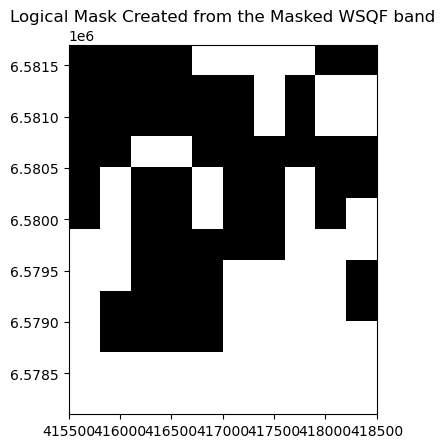

In [22]:
# 5. Create a logical mask based on our selected quality flags 
#  Uncomment one of the options to explore the alternatives described above!

# Option 1: Any Selected Bits Are Set (OR Logic)
#quality_mask = masked_wsqf > 0  # Keep pixels where at least one selected bit is set (OR logic)
#quality_mask = ~(masked_wsqf > 0)  # Filter pixels where at least one selected bit is set (OR logic)

# Option 2: All Selected Bits Are Set (AND Logic)
#quality_mask = masked_wsqf == selected_bits  # Keep pixels where all selected bits are set (AND logic)
quality_mask = ~(masked_wsqf == selected_bits)  # Filter pixels where all selected bits are set (AND logic)

qmask_data = quality_mask.download(format="gtiff")
title="Logical Mask Created from the Masked WSQF band"
qmask_image = show_result(qmask_data, title=title)
show_binary_image_thumbnail(qmask_image, title=title)


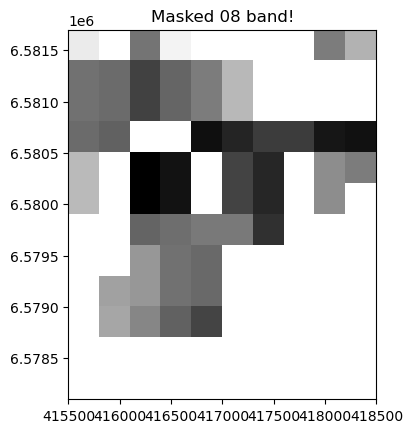

In [23]:
 # 6. Apply the quality mask to the oa08 band
masked_oa08 = oa08_band.mask(quality_mask)

# 7. Execute the masking and visualize the masked oa08 band
masked_data = masked_oa08.download(format="gtiff")
masked_image = show_result(masked_data, title="Masked 08 band!")

### Concluding Remarks

In this lab, we've explored two fundamental masking techniques in Earth Observation (EO) analysis using Sentinel data: the Scene Classification Layer (SCL) and Water Quality Science Flags (WQSF). These processes allow us to refine our datasets by selectively excluding or retaining pixels based on specific criteria, enhancing the accuracy and relevance of our analyses.

### Summary of SCL Masking Process

1. **Load the SCL Band**: Begin by loading the Sentinel-2 data cube that includes the Scene Classification Layer (SCL) band, which categorizes each pixel into different land cover classes (e.g., vegetation, water, clouds).

2. **Create a Value-Based Mask**: Identify the SCL value(s) corresponding to the land cover types you want to exclude (e.g., exclude all pixels classified as vegetation with `SCL == 4`).

3. **Apply the Mask**: Use the value-based mask to filter the relevant band(s) in your data cube, such as the Red Edge band, excluding the areas identified by the SCL mask.

4. **Visualize the Masked Result**: After applying the mask, visualize the data to confirm that the unwanted areas (e.g., vegetation) have been successfully excluded, leaving you with a focused dataset for further analysis.

### Summary of WQSF Masking Process

1. **Load the WQSF Band**: Start by loading the Sentinel-3 data cube that includes the WQSF band, which contains various quality flags for each pixel.

2. **Select the Relevant Bits**: Identify and select the specific bits that correspond to the quality conditions you want to focus on (e.g., cloud presence, sun glint).

3. **Create a Logical Mask**: Apply a bitwise operation to create a logical mask based on the selected bits. Decide whether to use OR (any selected bits set) or AND (all selected bits set) logic, depending on your analysis needs.

4. **Invert the Mask (if needed)**: Invert the mask if your intention is to retain only the pixels that meet the criteria defined by the selected bits. This step depends on whether you're masking out or keeping certain areas.

5. **Apply the Mask**: Finally, apply the logical mask to your data cube to exclude or retain the desired pixels, refining your analysis to focus on high-quality data.

### Final Exercise
A valuable exercise is to implement the above processes in one cell each by adapting the code provided. Writing your own code will help solidify your understanding and ensure you can apply these techniques effectively in your own work. 
